In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/E-commerce Dataset.csv")
df.head()

,Order_Date,Time,Aging,Customer_Id,Gender,Device_Type,Customer_Login_type,Product_Category,Product,Sales,Quantity,Discount,Profit,Shipping_Cost,Order_Priority,Payment_method
0,2018-01-02,10:56:33,8.0,37077,Female,Web,Member,Auto & Accessories,Car Media Players,140.0,1.0,0.3,46.0,4.6,Medium,credit_card
1,2018-07-24,20:41:37,2.0,59173,Female,Web,Member,Auto & Accessories,Car Speakers,211.0,1.0,0.3,112.0,11.2,Medium,credit_card
2,2018-11-08,08:38:49,8.0,41066,Female,Web,Member,Auto & Accessories,Car Body Covers,117.0,5.0,0.1,31.2,3.1,Critical,credit_card
3,2018-04-18,19:28:06,7.0,50741,Female,Web,Member,Auto & Accessories,Car & Bike Care,118.0,1.0,0.3,26.2,2.6,High,credit_card
4,2018-08-13,21:18:39,9.0,53639,Female,Web,Member,Auto & Accessories,Tyre,250.0,1.0,0.3,160.0,16.0,Critical,credit_card


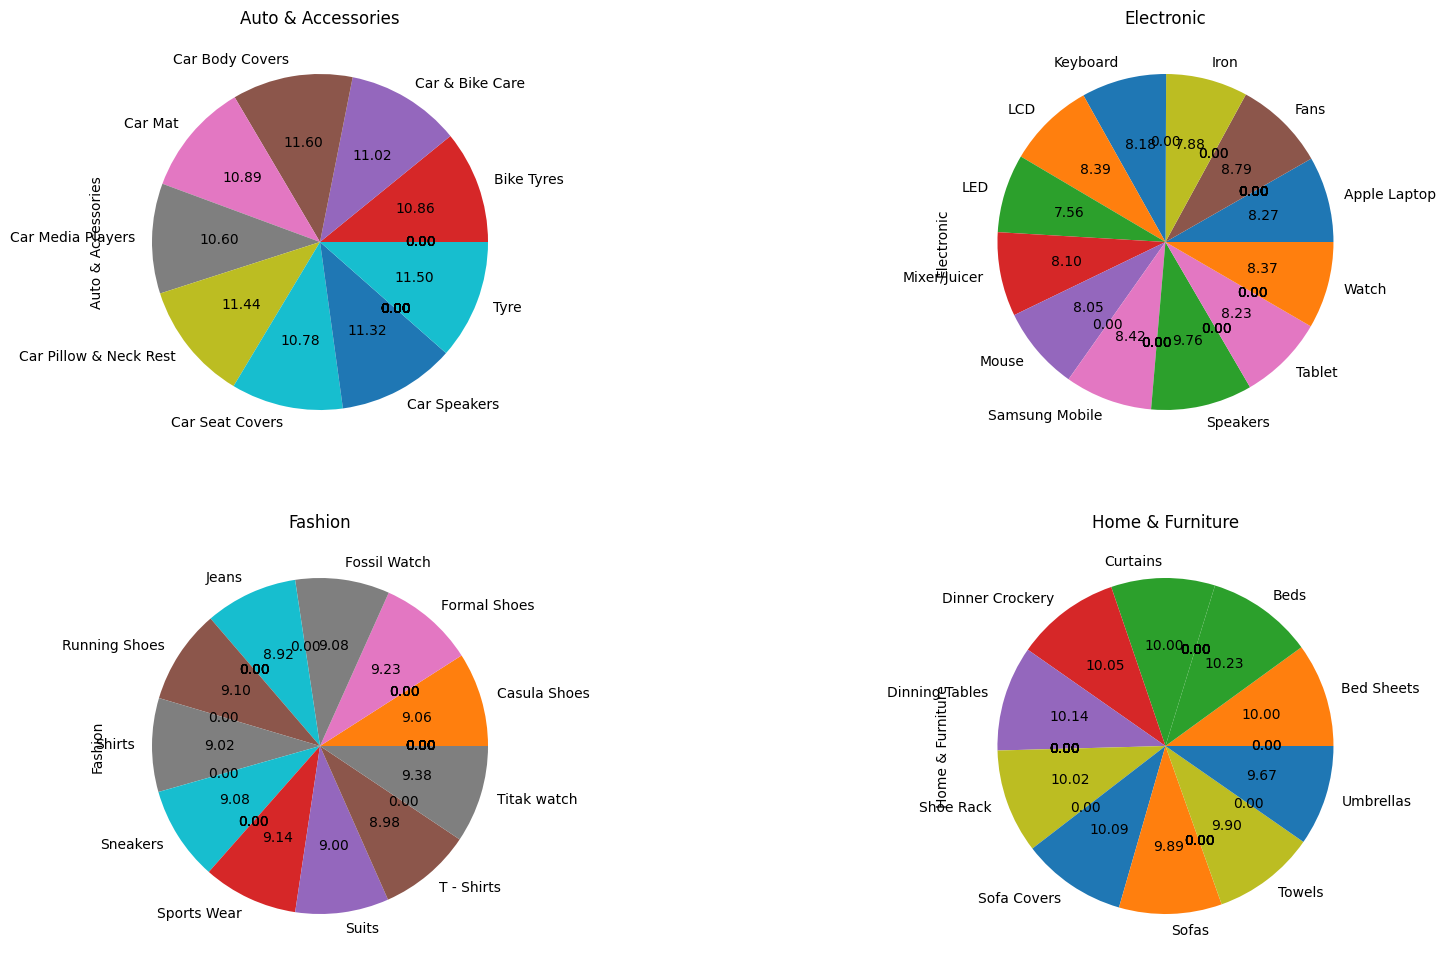

In [2]:
simple_pivot = pd.pivot_table(df, columns='Product_Category', index='Product',values='Quantity', aggfunc='sum').fillna(0)
fig, ax = plt.subplots(2, 2, figsize = (20, 12))
ax = ax.ravel()
for k, col in enumerate(simple_pivot.columns):
    simple_pivot[col].plot(kind='pie', ax = ax[k], autopct='%.2f')
    ax[k].set_title(col)
plt.show()

### 1. Top 3 product_category has highest & lowest Sales
- doanh số = Sales
- doanh thu = Profit/Revenue
#### 1.1. Using pandas

In [3]:
count_sale_prod_df = df.groupby('Product').sum()['Sales'].sort_values(ascending=False).astype(int).reset_index()
top3_prod_df = pd.concat([count_sale_prod_df.head(3), count_sale_prod_df.tail(3)])
top3_prod_df

,Product,Sales
0,T - Shirts,578336
1,Titak watch,531468
2,Running Shoes,522144
39,Mixer/Juicer,18592
40,LCD,14560
41,Keyboard,7293


## 2. Print out number of customers w.r.t each Band of 100$ from Profit

                        Revenue = Profit + Total_Expenses - Discount * Total_Expenses
                        Total_Expenses = Sales * Quantity + Shipping_Cost

                    =>  Revenue = Profit + (Sales * Quantity + Shipping_Cost) * (1 - Discount)

In [4]:
df['Revenue'] = df['Profit'] + (df['Sales']*df['Quantity'] + df['Shipping_Cost']) * (1 - df['Discount'])
df['Revenue'] = df['Revenue'].fillna(0)
df['band_100'] = df['Revenue'].apply(lambda x: f"{ int(x // 100)*100:4d} - {int(1 + x // 100)*100}")
df.groupby('band_100').count()[['Customer_Id']]

,Customer_Id
band_100,
0 - 100,5613
100 - 200,12038
200 - 300,10467
300 - 400,7820
400 - 500,4155
500 - 600,3270
600 - 700,2527
700 - 800,2058
800 - 900,1483


### 3. Cohort analysis

In [5]:
import datetime as dt
def get_month(x): return dt.datetime(x.year, x.month, 1)

df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['order_month'] = df['Order_Date'].apply(get_month)
# Grouping by customer_id and select the InvoiceMonth value
grouping = df.groupby('Customer_Id')['order_month']
# Assigning a minimum InvoiceMonth value to the dataset
df['CohortMonth'] = grouping.transform('min')
df.head()

,Order_Date,Time,Aging,Customer_Id,Gender,Device_Type,Customer_Login_type,Product_Category,Product,Sales,Quantity,Discount,Profit,Shipping_Cost,Order_Priority,Payment_method,Revenue,band_100,order_month,CohortMonth
0,2018-01-02,10:56:33,8.0,37077,Female,Web,Member,Auto & Accessories,Car Media Players,140.0,1.0,0.3,46.0,4.6,Medium,credit_card,147.22,100 - 200,2018-01-01,2018-01-01
1,2018-07-24,20:41:37,2.0,59173,Female,Web,Member,Auto & Accessories,Car Speakers,211.0,1.0,0.3,112.0,11.2,Medium,credit_card,267.54,200 - 300,2018-07-01,2018-07-01
2,2018-11-08,08:38:49,8.0,41066,Female,Web,Member,Auto & Accessories,Car Body Covers,117.0,5.0,0.1,31.2,3.1,Critical,credit_card,560.49,500 - 600,2018-11-01,2018-11-01
3,2018-04-18,19:28:06,7.0,50741,Female,Web,Member,Auto & Accessories,Car & Bike Care,118.0,1.0,0.3,26.2,2.6,High,credit_card,110.62,100 - 200,2018-04-01,2018-04-01
4,2018-08-13,21:18:39,9.0,53639,Female,Web,Member,Auto & Accessories,Tyre,250.0,1.0,0.3,160.0,16.0,Critical,credit_card,346.20,300 - 400,2018-08-01,2018-08-01


In [6]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day
# Getting the integers for date parts from the `InvoiceDay` column
transcation_year, transaction_month, _ = get_date_int(df, 'order_month')

# Getting the integers for date parts from the `CohortDay` column
cohort_year, cohort_month, _ = get_date_int(df, 'CohortMonth')

In [7]:
#  Get the  difference in years
years_diff = transcation_year - cohort_year
# Calculate difference in months
months_diff = transaction_month - cohort_month
""" Extract the difference in months from all previous values "+1" in addeded at the end so that first month is marked as 1 instead of 0 for easier interpretation. """
df['CohortIndex'] = years_diff * 12 + months_diff  + 1 
display(df.head(5))

,Order_Date,Time,Aging,Customer_Id,Gender,Device_Type,Customer_Login_type,Product_Category,Product,Sales,...,Discount,Profit,Shipping_Cost,Order_Priority,Payment_method,Revenue,band_100,order_month,CohortMonth,CohortIndex
0,2018-01-02,10:56:33,8.0,37077,Female,Web,Member,Auto & Accessories,Car Media Players,140.0,...,0.3,46.0,4.6,Medium,credit_card,147.22,100 - 200,2018-01-01,2018-01-01,1
1,2018-07-24,20:41:37,2.0,59173,Female,Web,Member,Auto & Accessories,Car Speakers,211.0,...,0.3,112.0,11.2,Medium,credit_card,267.54,200 - 300,2018-07-01,2018-07-01,1
2,2018-11-08,08:38:49,8.0,41066,Female,Web,Member,Auto & Accessories,Car Body Covers,117.0,...,0.1,31.2,3.1,Critical,credit_card,560.49,500 - 600,2018-11-01,2018-11-01,1
3,2018-04-18,19:28:06,7.0,50741,Female,Web,Member,Auto & Accessories,Car & Bike Care,118.0,...,0.3,26.2,2.6,High,credit_card,110.62,100 - 200,2018-04-01,2018-04-01,1
4,2018-08-13,21:18:39,9.0,53639,Female,Web,Member,Auto & Accessories,Tyre,250.0,...,0.3,160.0,16.0,Critical,credit_card,346.20,300 - 400,2018-08-01,2018-08-01,1


In [8]:
# Counting daily active user from each chort
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
# Counting number of unique customer Id's falling in each group of CohortMonth and CohortIndex
cohort_data = grouping['Customer_Id'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
 # Assigning column names to the dataframe created above
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                 columns ='CohortIndex',
                                 values = 'Customer_Id')
# Printing top 5 rows of Dataframe
cohort_data.head()

,CohortMonth,CohortIndex,Customer_Id
0,2018-01-01,1,2473
1,2018-01-01,2,64
2,2018-01-01,3,70
3,2018-01-01,4,117
4,2018-01-01,5,154


In [9]:
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
# Coverting the retention rate into percentage and Rounding off.
retention.round(3)*100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,
2018-01-01,100.0,2.6,2.8,4.7,6.2,4.2,6.0,4.5,5.8,5.4,6.3,6.1
2018-02-01,100.0,3.9,3.6,6.0,4.7,6.0,5.1,4.6,5.8,7.1,5.6,NaN
2018-03-01,100.0,4.4,6.4,4.7,5.3,5.4,5.4,5.7,6.7,4.8,NaN,NaN
2018-04-01,100.0,5.7,5.0,5.6,4.6,5.0,5.1,6.8,5.4,NaN,NaN,NaN
2018-05-01,100.0,4.6,5.4,4.9,5.5,5.9,5.8,6.1,NaN,NaN,NaN,NaN
2018-06-01,100.0,5.4,4.9,5.0,4.7,6.2,6.0,NaN,NaN,NaN,NaN,NaN
2018-07-01,100.0,4.3,5.1,5.1,6.3,5.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-01,100.0,5.4,5.3,6.0,5.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-01,100.0,5.6,5.9,5.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


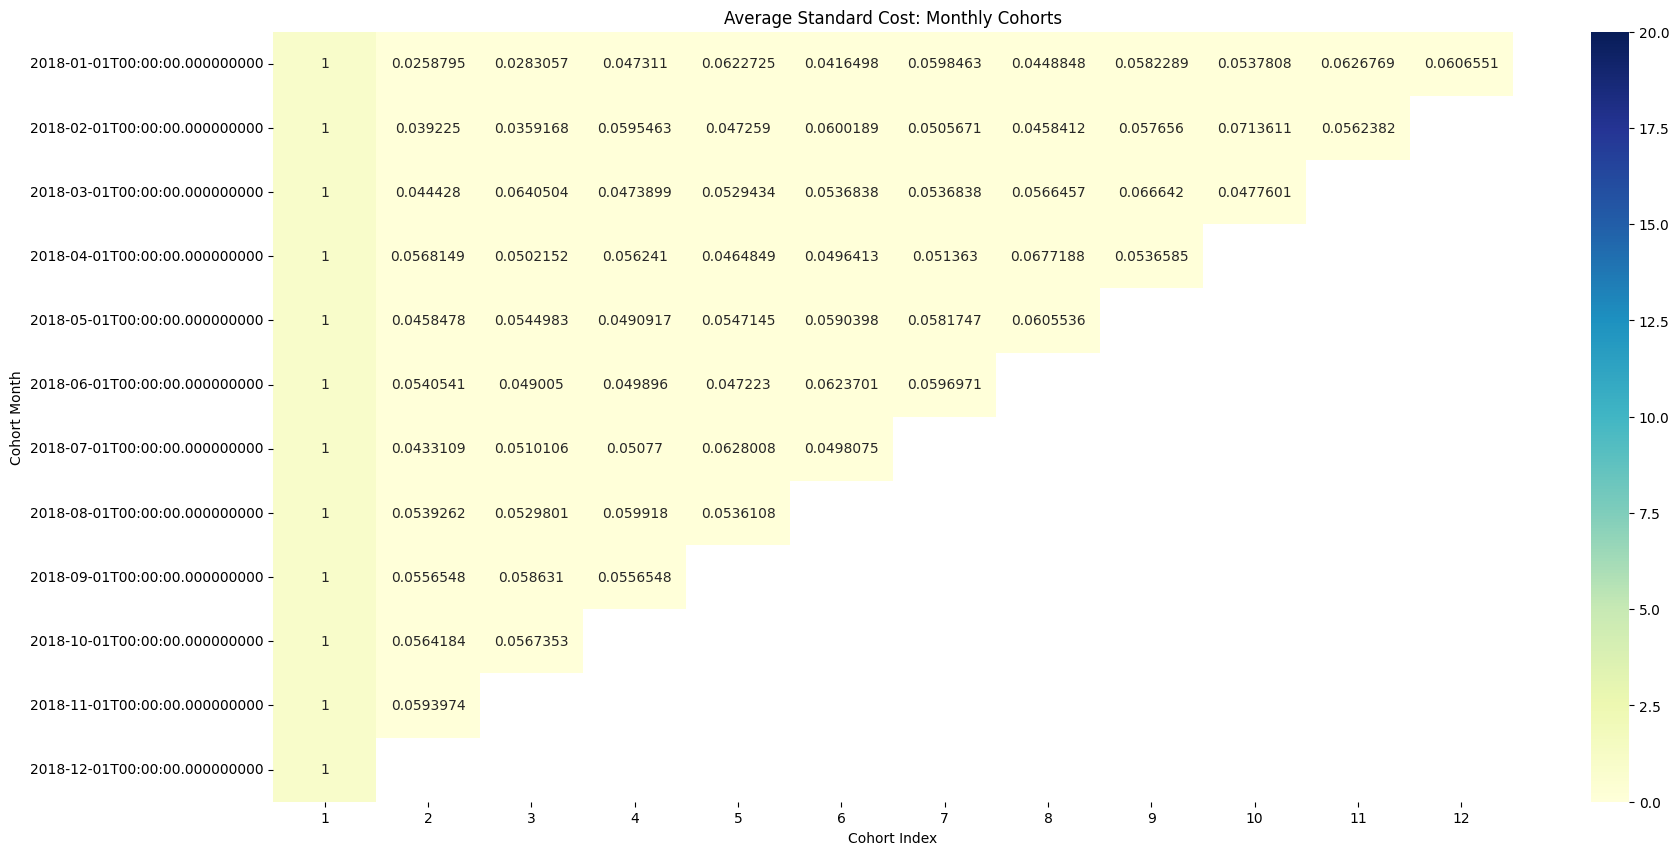

In [10]:
import seaborn as sns

#retention.index = retention.index.strftime('%Y-%m')
# Initialize the figure
plt.figure(figsize=(20, 10))
# Adding a title
plt.title('Average Standard Cost: Monthly Cohorts', fontsize = 12)
# Creating the heatmap
sns.heatmap(retention, annot = True,vmin = 0.0, vmax =20,cmap="YlGnBu", fmt='g')
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index')
plt.show()